# Annotate mPB cells in mobilized PB dataset through projection on reference (BM+PB) cells

In [1]:
%matplotlib widget

import warnings
warnings.filterwarnings('ignore')

import os, sys, math, re
import natsort, json, operator, getpass
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import scanpy as sc
import scanpy.external as sce

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets

In [2]:
with open('/.singularity.d/labels.json') as fh:
    singularity = json.load(fh)
    
singularity['Version']

'metztli.25j'

In [3]:
sc.settings.verbosity = 3             # show some output
sc.settings.file_format_figs = 'svg'  # set this to 'svg' (notebook) or 'pdf' (files) if you want vector graphics
sc.settings.savefigs = False

In [4]:
home = str(Path.home())
user = getpass.getuser()

In [5]:
"""
Allows to create a persistent png image from
the last plotted matplotlib plot widget
"""
def perma_plot():
    
    import base64
    from io import BytesIO
    from IPython.display import HTML
    
    # TODO: maybe pass parameters for savefig
    #       to control quality/type of img
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    
    encoded_string = base64.b64encode(buffer.read()).decode('utf-8')
    html_string = '<img src=\'data:image/png;base64,{}\'>'.format(encoded_string)
    
    return HTML(html_string)

---

In [6]:
basedir = os.path.join(home, 'databoard/users', user, '2021/BloodPaper/')

sc.settings.writedir = os.path.join(basedir, 'h5ad/')

In [7]:
now = datetime.now()
prefix = now.strftime('%Y%m%d')
print(prefix)

20211111


In [8]:
import cellproject_master.cellproject as cp

In [10]:
integrated = sc.read('20211110_COMBO_PB10PLUS_Seurat3_VST_classic_integrated')

In [11]:
integrated

AnnData object with n_obs × n_vars = 123158 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'groupset', 'library', 'donor', 'organ', 'annot'

In [12]:
integrated.obs.head()

,orig.ident,nCount_originalexp,nFeature_originalexp,groupset,library,donor,organ,annot
_01_AAACCTGCACGTCTCT.1.0,SeuratProject,10052.0,2399,ref,SIGAD9,DOD1,PB,02_MEP2
_01_AAACCTGGTGTGACGA.1.0,SeuratProject,14883.0,3609,ref,SIGAD9,DOD1,PB,13_MEP cycle
_01_AAACCTGGTTCCGGCA.1.0,SeuratProject,5546.0,1543,ref,SIGAD9,DOD1,PB,00_HSC/MPP2
_01_AAACGGGGTCAAAGCG.1.0,SeuratProject,4184.0,1159,ref,SIGAD9,DOD1,PB,00_HSC/MPP2
_01_AAAGATGCACATGACT.1.0,SeuratProject,12027.0,2548,ref,SIGAD9,DOD1,PB,00_HSC/MPP2


In [14]:
integrated.X.min(), integrated.X.max()

(-3.1309502, 7.5616503)

In [15]:
integrated.layers['seurat'] = integrated.X.copy()

In [16]:
sc.pp.scale(integrated)

In [17]:
integrated.X.min(), integrated.X.max()

(-34.653976, 133.54256)

In [18]:
sc.tl.pca(integrated, n_comps=30)

computing PCA
    with n_comps=30
    finished (0:00:16)


In [19]:
sc.pl.embedding(integrated, basis='pca', color=['donor'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
plt.subplots_adjust(right=.8)


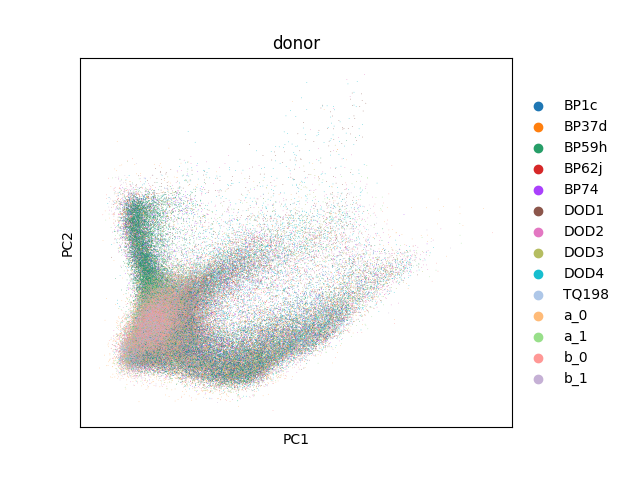

In [21]:
perma_plot()

In [23]:
integrated.uns['pca']

{'params': {'zero_center': True, 'use_highly_variable': False},
 'variance': array([93.08502968, 37.87807027, 25.46542421, 18.35639265, 14.10278445,
        12.49382597, 10.88668935,  9.14834114,  7.28833877,  6.72021739,
         5.74403099,  4.98191891,  4.78367602,  3.91053975,  3.7006514 ,
         3.33372012,  3.02819191,  2.8559722 ,  2.68808081,  2.53780413,
         2.4351463 ,  2.32226345,  2.27361848,  2.19515715,  2.1251898 ,
         2.00400162,  1.97964971,  1.91813549,  1.8360709 ,  1.82604876]),
 'variance_ratio': array([0.04654519, 0.01894013, 0.01273344, 0.00917872, 0.0070518 ,
        0.00624727, 0.00544366, 0.00457443, 0.00364438, 0.0033603 ,
        0.00287218, 0.0024911 , 0.00239198, 0.00195538, 0.00185043,
        0.00166696, 0.00151418, 0.00142807, 0.00134412, 0.00126898,
        0.00121764, 0.0011612 , 0.00113687, 0.00109764, 0.00106266,
        0.00100206, 0.00098988, 0.00095912, 0.00091809, 0.00091308])}

In [24]:
sc.pp.neighbors(integrated)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


In [25]:
integrated

AnnData object with n_obs × n_vars = 123158 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'groupset', 'library', 'donor', 'organ', 'annot'
    var: 'mean', 'std'
    uns: 'pca', 'donor_colors', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'seurat'
    obsp: 'distances', 'connectivities'

In [26]:
sc.tl.umap(integrated)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:37)


In [27]:
sc.pl.embedding(integrated, basis='umap', color='donor')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
plt.subplots_adjust(right=.8)


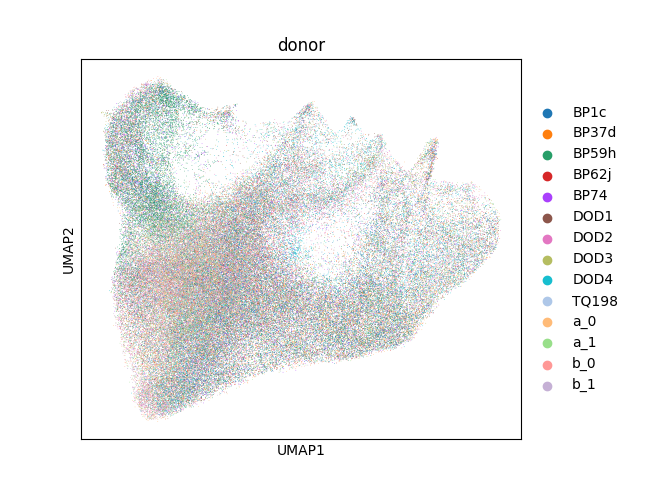

In [29]:
perma_plot()

In [33]:
%%time
sc.write(prefix+'_COMBO_PB10PLUS_Seurat_classic_integration_Scanpy_downstream_processed_basic', integrated)

CPU times: user 1min 13s, sys: 2.21 s, total: 1min 15s
Wall time: 1min 15s


### Cell projections and label transfer

---

In [46]:
integrated

AnnData object with n_obs × n_vars = 123158 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'groupset', 'library', 'donor', 'organ', 'annot'
    var: 'mean', 'std'
    uns: 'pca', 'donor_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'seurat'
    obsp: 'distances', 'connectivities'

In [47]:
#Splitting combined dataset
ref = integrated[integrated.obs.groupset == 'ref', :].copy()
target = integrated[integrated.obs.groupset == 'target', :].copy()

In [48]:
%%time
#Transferring the 'annot' column
cp.project_cells(target, ref,
                       obs_columns=['annot'],
                       fit_pca=False,
                       scale_data=False)

No valid UMAP object provided, UMAP parameters left unmodified
CPU times: user 4min 7s, sys: 10.8 s, total: 4min 18s
Wall time: 4min 18s


In [49]:
sc.pl.umap(target, color=['ref_annot'])

... storing 'ref_annot' as categorical


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [50]:
plt.subplots_adjust(right=0.8)

In [51]:
axes = plt.gcf().get_axes()

handles, labels = axes[-1].get_legend_handles_labels()
axes[-1].legend(handles, labels)

lgnd = axes[-1].legend(handles, labels, loc=7, scatterpoints=1, 
                       frameon=False, fontsize=8, 
                       bbox_to_anchor=(1.275, 0.5))


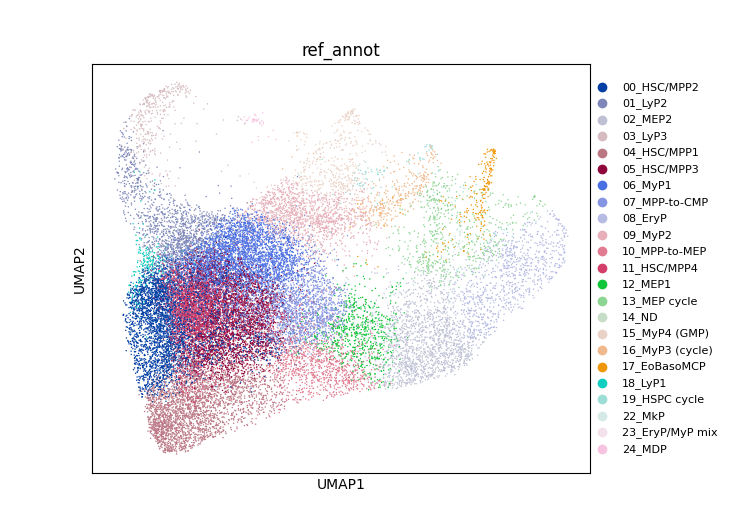

In [52]:
perma_plot()

In [53]:
%%time
sc.write(prefix+'_4x_mPB_COMBO_PB10PLUS_integrated_cellproject_annotated', target)

CPU times: user 14.4 s, sys: 512 ms, total: 14.9 s
Wall time: 15 s


In [54]:
target.obs.groupby(['donor', 'ref_annot']).size().unstack()

ref_annot,00_HSC/MPP2,01_LyP2,02_MEP2,03_LyP3,04_HSC/MPP1,05_HSC/MPP3,06_MyP1,07_MPP-to-CMP,08_EryP,09_MyP2,...,13_MEP cycle,14_ND,15_MyP4 (GMP),16_MyP3 (cycle),17_EoBasoMCP,18_LyP1,19_HSPC cycle,22_MkP,23_EryP/MyP mix,24_MDP
donor,,,,,,,,,,,,,,,,,,,,,
a_0,955,391,839,103,659,834,980,599,403,374,...,252,98,102,27,121,65,17,15,1,31
a_1,1024,517,382,88,645,716,671,525,330,336,...,188,46,155,121,55,59,44,28,0,5
b_0,1025,390,165,111,601,630,687,570,21,332,...,57,42,87,61,18,61,36,1,0,0
b_1,1151,420,192,117,832,699,687,580,167,356,...,95,47,96,133,38,52,34,5,0,2


In [55]:
target.obs.groupby(['donor', 'ref_annot']).size().unstack().to_csv('output/'+prefix+'_PB10PLUS_integration_4x_mPB_C10_annots_counts_per_donor.txt', sep='\t')

In [57]:
meta = target.obs[['library', 'donor', 'organ', 'annot', 'ref_annot']].copy()

In [59]:
meta.columns = ['library', 'donor', 'organ', 'first_annot', 'ref_annot']

In [60]:
meta.to_csv('output/'+prefix+'_PB10PLUS_integration_4x_mPB_C10_annot_ULTIMATE_metadata.txt', sep='\t')

In [61]:
ref.obs.head()

,orig.ident,nCount_originalexp,nFeature_originalexp,groupset,library,donor,organ,annot
_01_AAACCTGCACGTCTCT.1.0,SeuratProject,10052.0,2399,ref,SIGAD9,DOD1,PB,02_MEP2
_01_AAACCTGGTGTGACGA.1.0,SeuratProject,14883.0,3609,ref,SIGAD9,DOD1,PB,13_MEP cycle
_01_AAACCTGGTTCCGGCA.1.0,SeuratProject,5546.0,1543,ref,SIGAD9,DOD1,PB,00_HSC/MPP2
_01_AAACGGGGTCAAAGCG.1.0,SeuratProject,4184.0,1159,ref,SIGAD9,DOD1,PB,00_HSC/MPP2
_01_AAAGATGCACATGACT.1.0,SeuratProject,12027.0,2548,ref,SIGAD9,DOD1,PB,00_HSC/MPP2


In [63]:
ref.obs['ref_annot'] = ref.obs['annot'].copy()

In [64]:
intgr_comb = ref.concatenate(target, index_unique=None)
intgr_comb.shape

(123158, 2000)

In [65]:
intgr_comb.obs.head()

,orig.ident,nCount_originalexp,nFeature_originalexp,groupset,library,donor,organ,annot,ref_annot,batch
_01_AAACCTGCACGTCTCT.1.0,SeuratProject,10052.0,2399,ref,SIGAD9,DOD1,PB,02_MEP2,02_MEP2,0
_01_AAACCTGGTGTGACGA.1.0,SeuratProject,14883.0,3609,ref,SIGAD9,DOD1,PB,13_MEP cycle,13_MEP cycle,0
_01_AAACCTGGTTCCGGCA.1.0,SeuratProject,5546.0,1543,ref,SIGAD9,DOD1,PB,00_HSC/MPP2,00_HSC/MPP2,0
_01_AAACGGGGTCAAAGCG.1.0,SeuratProject,4184.0,1159,ref,SIGAD9,DOD1,PB,00_HSC/MPP2,00_HSC/MPP2,0
_01_AAAGATGCACATGACT.1.0,SeuratProject,12027.0,2548,ref,SIGAD9,DOD1,PB,00_HSC/MPP2,00_HSC/MPP2,0
